# Variational Autoencoder (VAE)

In [1]:
import math
import numpy as np
from gymnasium.utils import seeding
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import cv2

CHECKPOINTS = 12
SCALE       = 6.0
TRACK_RAD   = 900/SCALE
TRACK_TURN_RATE = 0.31
TRACK_DETAIL_STEP = 21/SCALE
PLAYFIELD   = 2000/SCALE # Game over boundary

IMG_SIZE = 32  # Pixels

np_random, seed = seeding.np_random(7)

In [44]:
from gym_multi_car_racing import bezier

def get_track(control_points=None, mindst=0.08, np_random=np_random):
    if control_points is not None:
        a = np.array(control_points)
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)
    else:
        a = bezier.get_random_points(n=12, scale=PLAYFIELD, mindst=mindst, np_random=np_random) // 30 * 30
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)

    x, y = np.clip(0, x.max(), x), np.clip(0, y.max(), y)

    return a, x, y

In [31]:
def plot_track(track, checkpoints=None):
    # Plot track
    plt.plot(track[:,1], track[:,0], linewidth=9, color=[0.4, 0.4, 0.4])

    # Plot checkpoints
    if checkpoints is not None:
        for i in range(len(checkpoints)):
            y, x = checkpoints[i,:]
            plt.plot(x, y, 'o', markersize=2, color="tab:orange")
            plt.text(x, y, str(i), fontsize=10, color="black")
    
    plt.xlim(-20,360)
    plt.ylim(-20,360)

    ax = plt.gca()
    ax.set_facecolor(np.array([102, 230, 102])/255.)

## Generate tracks

In [32]:
def get_image(coordinates, img_size=(32,32)):
    max_value = 330 if coordinates.max() < 330 else coordinates.max()

    if coordinates[:,0].min() < 0:
        coordinates[:,0] = coordinates[:,0] - coordinates[:,0].min()
    if coordinates[:,1].min() < 0:
        coordinates[:,1] = coordinates[:,1] - coordinates[:,1].min()
    coordinates = coordinates // (max_value/(img_size[0]-1))
    coordinates = coordinates.astype(np.int32)

    # Clip to 0-31
    coordinates = np.clip(coordinates, 0, img_size[0]-1)
    
    img = np.zeros(img_size)

    for i in range(coordinates.shape[0]):
        img[coordinates[i,1], coordinates[i,0]] = 1

    return img

In [33]:
from PIL import Image, ImageDraw
import numpy as np

def get_image_(points, img_size=(32, 32)):
    """
    Create a 2D image of a curve using a set of points.

    Parameters:
    - points: List of tuples representing (x, y) coordinates of the curve.
    - img_size: Tuple representing the size of the image (width, height).

    Returns:
    - img_array: NumPy array representing the image.

    Example:
    >>> points = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16)]
    >>> image_array = get_image(points)
    """
    # Find the bounding box of the points
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    # Create a blank image with a black background
    width = int(max_x - min_x) + 20
    height = int(max_y - min_y) + 20
    image = Image.new("RGB", (width, height), "black")
    draw = ImageDraw.Draw(image)

    # Translate points to the image coordinates
    translated_points = [(x - min_x + 10, y - min_y + 10) for x, y in points]

    # Draw the curve on the image
    draw.line(translated_points, fill="white", width=2)

    # Convert the PIL image to a NumPy array
    img_array = np.array(image)

    # Convert to grayscale
    img_array = np.mean(img_array, axis=2)

    # Resize image
    width, height = img_size
    img_array = cv2.resize(img_array, dsize=(width, height), interpolation=cv2.INTER_AREA)

    # Normalize pixel values
    img_array = img_array / img_array.max()

    return img_array

Calculate track complexity using the function taken from the dcd repository.

In [34]:
import math
import os
import pandas as pd
import geopandas as gpd
import shapely


def get_notches(poly):
    """
    Determine the number of notches in a polygon object and calculate 
    normalized notches of polygon
    
    Based on: 
        "Measuring the Complexity of Polygonal Objects" 
        (Thomas Brinkhoff, Hans-Peter Kriegel, Ralf Schneider, Alexander Braun)
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.73.1045&rep=rep1&type=pdf
        
        https://github.com/pondrejk/PolygonComplexity/blob/master/PolygonComplexity.py
        
    @poly (Shapely Polygon object)
    
    Returns normalized notches
    """
    notches = 0 
    coords = list(poly.exterior.coords)
    for i, pt in enumerate(coords[:-1]):
        x_diff = coords[i+1][0] - pt[0]
        y_diff = coords[i+1][1] - pt[1]
        angle = math.atan2(y_diff, x_diff)
        if angle < 0: 
            angle += 2*math.pi
        if angle > math.pi:
            notches += 1
    
    if notches != 0:
        notches_norm = notches / (len(coords)-3)
    else:
        notches_norm = 0 
        
    return notches_norm

def get_stats(gdf, coeff_ampl, coeff_conv):
    """
    Get polygon's amplitude of vibration:
    
    ampl(pol) = (boundary(pol) - boundary(convexhull(pol))) / boundary(pol)
    
    Get deviation from convex hull:
    conv(pol) = (area(convexhull(pol)) - area(pol)) / area(convexhull(pol))
    
    Measure complexity
    
     Based on: 
        "Measuring the Complexity of Polygonal Objects" 
        (Thomas Brinkhoff, Hans-Peter Kriegel, Ralf Schneider, Alexander Braun)
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.73.1045&rep=rep1&type=pdf
        
        https://github.com/pondrejk/PolygonComplexity/blob/master/PolygonComplexity.py
    
    Get area, centroid, distance from each others, boudary, convex hull, 
    perimeter, number of vertices.
    
    Returns tuple with dict of stats values and GeoDataframe with stats
    """
    nb = gdf['geometry'].count()
    gdf['area'] = gdf['geometry'].area
    tot_area = gdf['area'].sum()
    gdf['centroid'] = gdf['geometry'].centroid
    gdf['boundary'] = gdf['geometry'].boundary
    gdf['convex_hull'] = gdf['geometry'].convex_hull
    gdf['convex_boundary'] = gdf['geometry'].convex_hull.boundary
    gdf['convex_area'] = gdf['geometry'].convex_hull.area
    gdf['nbvertices'] = gdf['geometry'].apply(lambda x: len(list(x.exterior.coords)))
    gdf['notches'] = gdf['geometry'].apply(lambda x: get_notches(x))
    
    gdf['amplitude'] = gdf.apply(
            lambda x:(
                    x['boundary'].length - x['convex_boundary'].length
                    ) / (x['boundary'].length + 1e-3), 
                    axis=1)
    gdf['convex'] = gdf.apply(
            lambda x: (
                    x['convex_area'] - x['area']
                    ) / (x['convex_area'] + 1e-3),
                    axis=1)
    gdf['complexity'] = gdf.apply(
            lambda x: coeff_ampl*x['amplitude'] * x['notches'] + coeff_conv * x['convex'],
            axis=1
            )
    
    mean_amplitude = gdf['amplitude'].mean()
    mean_convex = gdf['convex'].mean()
    mean_norm_notches = gdf['notches'].mean()
    mean_complexity = gdf['complexity'].mean()
    
    gdf['perimeter'] = gdf['geometry'].length
    tot_perimeter = gdf['perimeter'].sum()
    
    if ("lat" in gdf.columns) or ("lon" in gdf.columns):
        columns_drop = ["boundary", "convex_hull", "convex_boundary", "convex_area", "centroid", "lat", "lon"]
    else:
        columns_drop = ["boundary", "convex_hull", "convex_boundary", "convex_area", "centroid"]
    gdf = gdf.drop(columns_drop, axis=1)
    
    gdf = gdf.reset_index()
    
    if nb > 1:
        gdf = gdf.sort_values(by='perimeter', ascending=False)
        gdf = gdf.iloc[[0]]
    
    return {
        'area':tot_area,
        'perimeter':tot_perimeter,
        'amplitude': mean_amplitude,
        'convex': mean_convex,
        'notches': mean_norm_notches,
        'complexity': mean_complexity
    }, gdf
            
def complexity(points, coeff_ampl=0.8, coeff_conv=0.2):
    polygon = shapely.geometry.Polygon(points)
    gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([polygon]))
    dict_complexity, gdf = get_stats(gdf, coeff_ampl, coeff_conv)        

    return dict_complexity

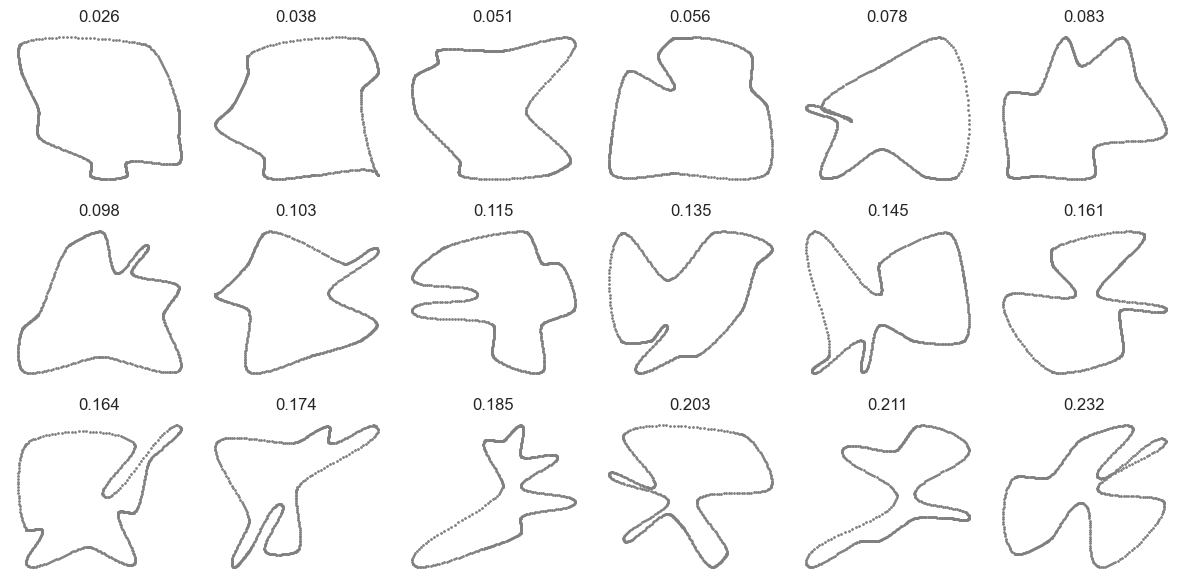

In [7]:
complexities = []
points = []
convexities = []
notches = []

# Complexities
comps = np.linspace(0.02, 0.22, num=18)
# Add one more element to the array
comps = np.append(comps, 0.5)

for i in range(18):
    comp = 1
    while (comp < comps[i] or comp > comps[i+1]):
        control_points, x, y = get_track(np_random=np_random)
        p = np.array(list(zip(x, y)))
        comp = complexity(p)['complexity']

    complexities.append(comp)
    convexities.append(complexity(p)['convex'])
    notches.append(complexity(p)['notches'])
    points.append(p)

# Sort by complexity
complexities = np.array(complexities)
idx = np.argsort(complexities)
complexities = complexities[idx]
points = np.array(points)[idx]

plt.figure(figsize=(12,6))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.scatter(points[i][:,0], points[i][:,1], color="gray", s=1)
    title = f"{np.round(complexities[i], 3)}" #\nconv: {np.round(convexities[i], 3)}\nnotches: {np.round(notches[i], 3)}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()

In [7]:
X = np.load("X.npy")

In [10]:
complexities = []

for i in range(X.shape[0]):
    control_points, x, y = get_track(X[i]*30, np_random=np_random)
    p = np.array(list(zip(x, y)))
    complexities.append(complexity(p)['complexity'])

    print(f"Progress: {i+1}/{X.shape[0]}", end="\r")

In [11]:
complexities = np.array(complexities)
np.save("complexities.npy", complexities)

Generate random tracks

In [8]:
NUM_TRACKS = 20_000
IMG_SIZE = (12,12)

X = []  # Track control points
Y = []  # Track low resolution image

for i in range(NUM_TRACKS):
    print(f"Generating track {i+1}/{NUM_TRACKS}", end="\r")
    # Generate random track
    checkpoints, x, y = get_track(np_random=np_random)
    X.append(checkpoints)
    # Get image from track
    track = np.array([x, y]).T
    Y.append(get_image_(track, img_size=IMG_SIZE))
    #Y.append(np.zeros(IMG_SIZE))

X = np.array(X).astype(np.float32) // 30  # Scale down to 0-11
Y = np.array(Y).astype(np.float32)

X.shape, Y.shape

((10000, 12, 2), (10000, 12, 12))

Generate random tracks with a uniform distribution of complexity

In [106]:
# Create 10 bins of complexity from 0 to 0.25
num_bins = 8
bins = np.linspace(0, 0.25, num_bins+1)
bins

array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   ])

In [289]:
NUM_TRACKS = 20_000
IMG_SIZE = (12,12)

X = []  # Track control points
Y = []  # Track low resolution image

NUM_TRACKS_PER_BIN = NUM_TRACKS // num_bins

for i in range(num_bins):
    for j in range(NUM_TRACKS_PER_BIN):
        comp = -1
        while (comp < bins[i] or comp > bins[i+1]):
            # Generate random track
            checkpoints, x, y = get_track(np_random=np_random)
            track = np.array(list(zip(x, y)))
            comp = complexity(track)['complexity']
            print(f"(Bin {i}) Generating track {j+1}/{NUM_TRACKS_PER_BIN}, complexity: {comp:.3f}", end="\r")#
        X.append(checkpoints)
        Y.append(get_image_(track, img_size=IMG_SIZE))
        #Y.append(np.zeros(IMG_SIZE))

X = np.array(X).astype(np.float32) // 30  # Scale down to 0-11
Y = np.array(Y).astype(np.float32)


X.shape, Y.shape

((20000, 12, 2), (20000, 12, 12))

In [54]:
X_sorted = np.copy(X)

# Sort the points in each track by y-coordinate first and then by x-coordinate
for i in range(X.shape[0]):
    X_sorted[i] = X[i][X[i][:,1].argsort()]
    X_sorted[i] = X_sorted[i][X_sorted[i][:,0].argsort()]

Text(0.5, 1.0, '13273: Sorted')

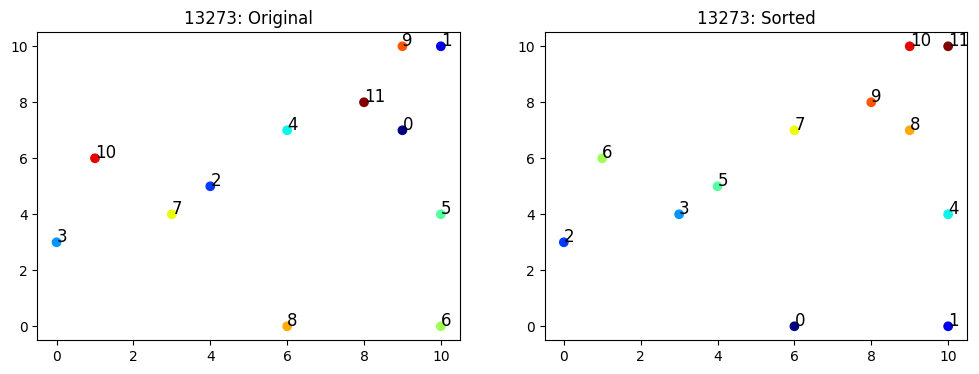

In [55]:
idx = np.random.choice(range(X.shape[0]), 1, replace=False)[0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter(X[idx][:,1], X[idx][:,0], c=range(12), cmap="jet")
# Add number to each point
for i in range(12):
    plt.text(X[idx][i,1], X[idx][i,0], str(i), fontsize=12, color="black")
plt.title(f"{idx}: Original")

plt.subplot(122)
plt.scatter(X_sorted[idx][:,1], X_sorted[idx][:,0], c=range(12), cmap="jet")
# Add number to each point
for i in range(12):
    plt.text(X_sorted[idx][i,1], X_sorted[idx][i,0], str(i), fontsize=12, color="black")
plt.title(f"{idx}: Sorted")

In [56]:
np.save("X.npy", X_sorted)

Create dataset

In [96]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class TracksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, tracks, checkpoints=None):
        self.tracks = tracks
        self.checkpoints = checkpoints

    def __len__(self):
        return len(self.tracks)

    def __getitem__(self, index):
        x = TF.to_tensor(self.tracks[index])
        if self.checkpoints is not None:
            y = TF.to_tensor(self.checkpoints[index])
        else:
            y = None
        return x, y

In [97]:
# Load data
X = np.load("X.npy")
Y = np.zeros((X.shape[0], 1))
X.shape

(20000, 12, 2)

In [98]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Create datasets
train_dataset = TracksDataset(np.expand_dims(X_train, axis=-1), np.expand_dims(Y_train, axis=-1))
val_dataset = TracksDataset(np.expand_dims(X_val, axis=-1), np.expand_dims(Y_val, axis=-1))

## Train VAE
Based on https://github.com/sksq96/pytorch-vae/blob/master

In [99]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, hidden_dim//8),
            nn.ReLU(),
            nn.Linear(hidden_dim//8, hidden_dim//16),
            nn.ReLU(),
            nn.Linear(hidden_dim//16, latent_dim * 2)  # Two outputs for mean and variance
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//16),
            nn.ReLU(),
            nn.Linear(hidden_dim//16, hidden_dim//8),
            nn.ReLU(),
            nn.Linear(hidden_dim//8, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        # Encode
        z_params = self.encoder(x)
        mu = z_params[:, :latent_dim]
        logvar = z_params[:, latent_dim:]
        z = self.reparameterize(mu, logvar)
        
        # Decode
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [100]:
import torch
from scipy.optimize import linear_sum_assignment

def reorder_coordinates(array1, array2):
    # Convert arrays to PyTorch tensors
    array1 = torch.tensor(array1)
    array2 = torch.tensor(array2)

    # Calculate the squared distances between each pair of points in the two arrays
    distances = torch.sum((array1[:, None, :] - array2[None, :, :]) ** 2, dim=-1)

    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(distances)

    # Reorder array2 according to the optimal assignment
    reordered_array2 = array2[col_ind]

    return reordered_array2

In [101]:
# Loss function
def loss_function(x_hat, x, mu, logvar):

    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_divergence

In [102]:
def train_vae(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, early_stopping={'patience': 5, 'min_delta': 0.001}):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for x, _ in train_loader:
            optimizer.zero_grad()

            # Flatten the input data if it's not already flattened
            x = x.view(x.size(0), -1)
            x = x.to(device)

            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.view(x.size(0), -1)
                x = x.to(device)

                x_hat, mu, logvar = model(x)
                loss = loss_function(x_hat, x, mu, logvar)

                val_loss += loss.item()
        val_loss /= len(val_loader.dataset)

        average_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {average_loss:.4f}, val_loss: {val_loss:.4f}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break

    print('Training finished.')

    return loss_history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

input_dim = 12 *2
hidden_dim = 2048
latent_dim = 12
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device)

batch_size = 32
num_epochs = 2_000
early_stopping = {'patience': 15, 'min_delta': 0.005}

# Data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train VAE
loss_history = train_vae(vae_model,
                        train_loader,
                        val_loader,
                        num_epochs=num_epochs,
                        learning_rate=1e-4,
                        early_stopping=early_stopping)

Device: cuda
Epoch [1/2000], train_loss: 169.3474, val_loss: 134.8534
Epoch [2/2000], train_loss: 132.8926, val_loss: 133.1618
Epoch [3/2000], train_loss: 128.7215, val_loss: 126.5607
Epoch [4/2000], train_loss: 123.1531, val_loss: 123.0813
Epoch [5/2000], train_loss: 117.9143, val_loss: 115.8523
Epoch [6/2000], train_loss: 104.6095, val_loss: 100.1884
Epoch [7/2000], train_loss: 93.4218, val_loss: 88.6015
Epoch [8/2000], train_loss: 81.2807, val_loss: 77.7765
Epoch [9/2000], train_loss: 71.1046, val_loss: 67.8579
Epoch [10/2000], train_loss: 62.0791, val_loss: 60.1999
Epoch [11/2000], train_loss: 54.6658, val_loss: 54.1083
Epoch [12/2000], train_loss: 50.4256, val_loss: 49.4646
Epoch [13/2000], train_loss: 47.6859, val_loss: 47.1212
Epoch [14/2000], train_loss: 44.5501, val_loss: 43.9727
Epoch [15/2000], train_loss: 42.4113, val_loss: 42.0584
Epoch [16/2000], train_loss: 41.2431, val_loss: 41.1583
Epoch [17/2000], train_loss: 40.5658, val_loss: 40.6298
Epoch [18/2000], train_loss: 39.

(20.0, 50.0)

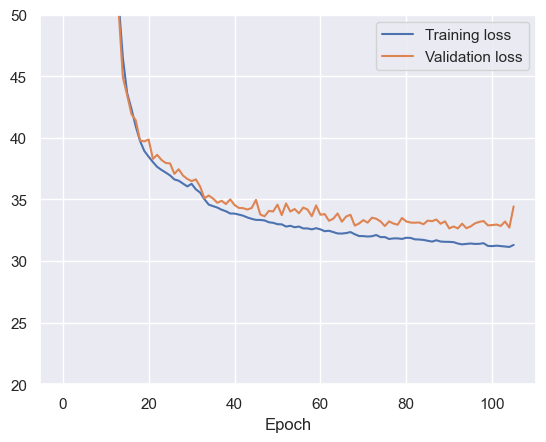

In [15]:
# Plot training and validation loss
plt.plot(loss_history['train_loss'], label="Training loss")
plt.plot(loss_history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.legend()
plt.ylim(20,50)

In [16]:
# Save VAE model
torch.save(vae_model.state_dict(), f"models/vae_points_h={hidden_dim}_z={latent_dim}.pt")

In [17]:
input_dim = 12 *2
hidden_dim = 2048
latent_dim = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load VAE model
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device) # GPU
vae_model.load_state_dict(torch.load(f"models/vae_points_h={hidden_dim}_z={latent_dim}.pt"))
vae_model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=24, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=24, bias=True)
  )
)

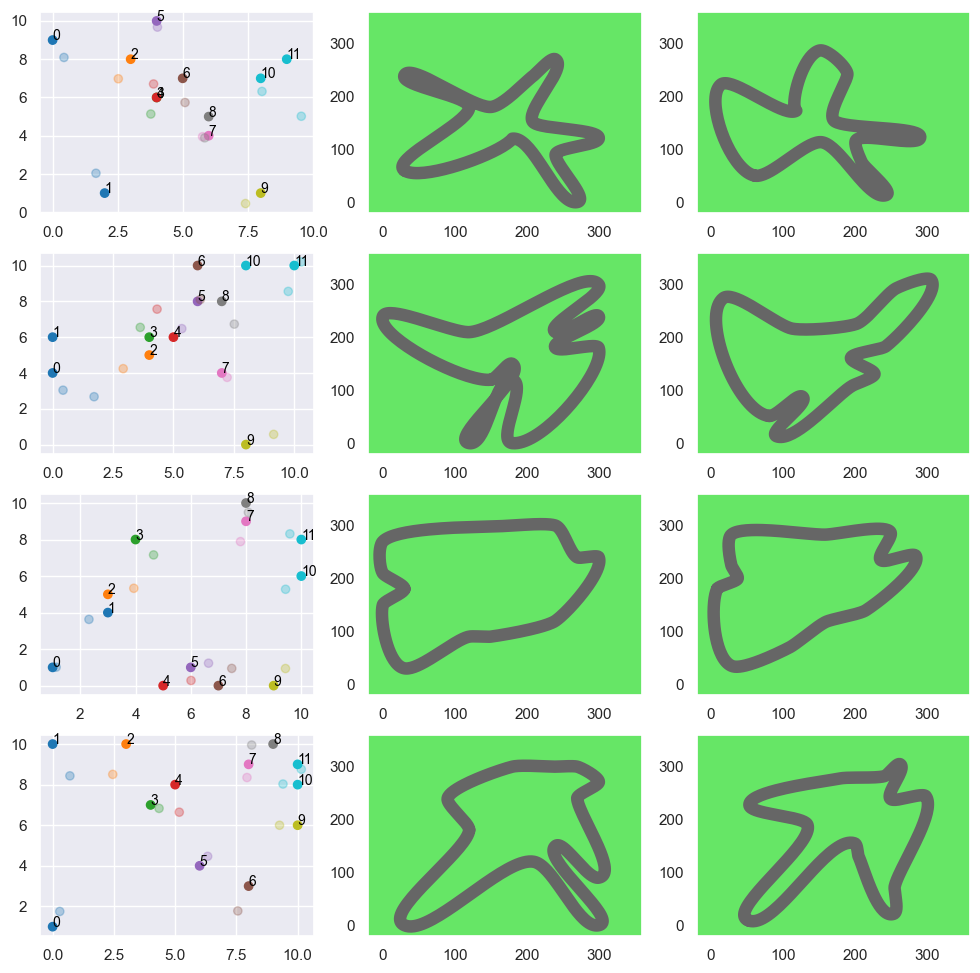

In [18]:
n_images = 4

plt.figure(figsize=(12, int(n_images*3)))

for i in range(n_images):
    j = np.random.randint(0, X_val.shape[0])
    x = val_dataset[j][0]
    y = val_dataset[j][1]
    control_points, x_, y_ = get_track(control_points=x.cpu().squeeze()*30, np_random=np_random)
    track = np.array([x_, y_]).T
    x = x.view(1, -1).to(device)
    recon_x, _, _ = vae_model.to(device)(x)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze()
    recon_x = recon_x.reshape(12,2)
    control_points_recon, x_recon, y_recon = get_track(control_points=recon_x*30, np_random=np_random)
    track_recon = np.array([x_recon, y_recon]).T

    # Plot original and reconstructed points
    plt.subplot(4,3,1+3*i)
    plt.scatter(x.cpu().squeeze().reshape(12,2)[:,0], x.cpu().squeeze().reshape(12,2)[:,1], cmap="tab10", c=range(12))
    plt.scatter(recon_x[:,0], recon_x[:,1], cmap="tab10", alpha=0.3, c=range(12))

    # Plot number for every point
    for p in range(12):
        plt.text(x.cpu().squeeze().reshape(12,2)[p,0], x.cpu().squeeze().reshape(12,2)[p,1], str(p), fontsize=10, color="black")

    # Plot original track
    plt.subplot(4,3,1+3*i+1)
    plot_track(track)
    plt.grid()

    # Plot reconstructed track
    plt.subplot(4,3,1+3*i+2)
    plot_track(track_recon)
    plt.grid()

__________

Analyze latent space

In [23]:
# Encode X
X_hat, mu, logvar = vae_model(torch.tensor(X).view(-1, 24).float().to(device))
X_hat = X_hat.to('cpu').detach().numpy().reshape(-1, 12, 2)
z = vae_model.reparameterize(mu, logvar).to('cpu').detach().numpy()

In [17]:
complexities = np.load("complexities.npy")

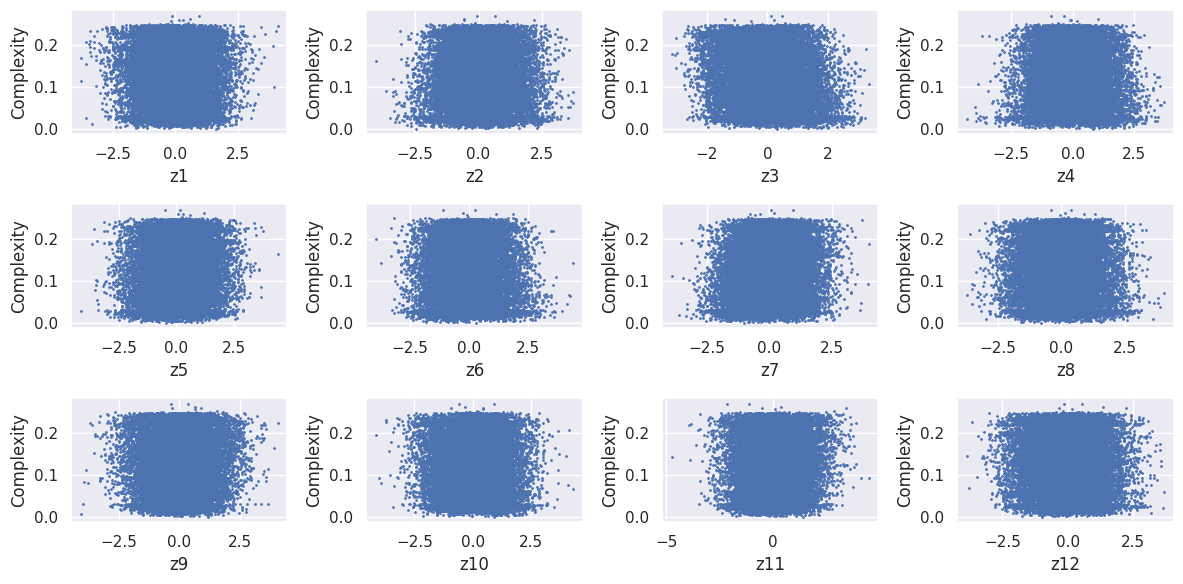

In [18]:
# Plot latent variables against complexity
plt.figure(figsize=(12,6))

for i in range(latent_dim):
    plt.subplot(3, 4, i+1)
    plt.scatter(z[:,i], complexities, s=1)
    plt.xlabel(f"z{i+1}")
    plt.ylabel("Complexity")
plt.tight_layout()

Calculate complexity of reconstructed tracks

In [24]:
complexities_hat = []

for i in range(X.shape[0]):
    control_points, x, y = get_track(X_hat[i]*30, np_random=np_random)
    p = np.array(list(zip(x, y)))
    complexities_hat.append(complexity(p)['complexity'])

    print(f"Progress: {i+1}/{X_hat.shape[0]}", end="\r")

complexities_hat = np.array(complexities_hat)

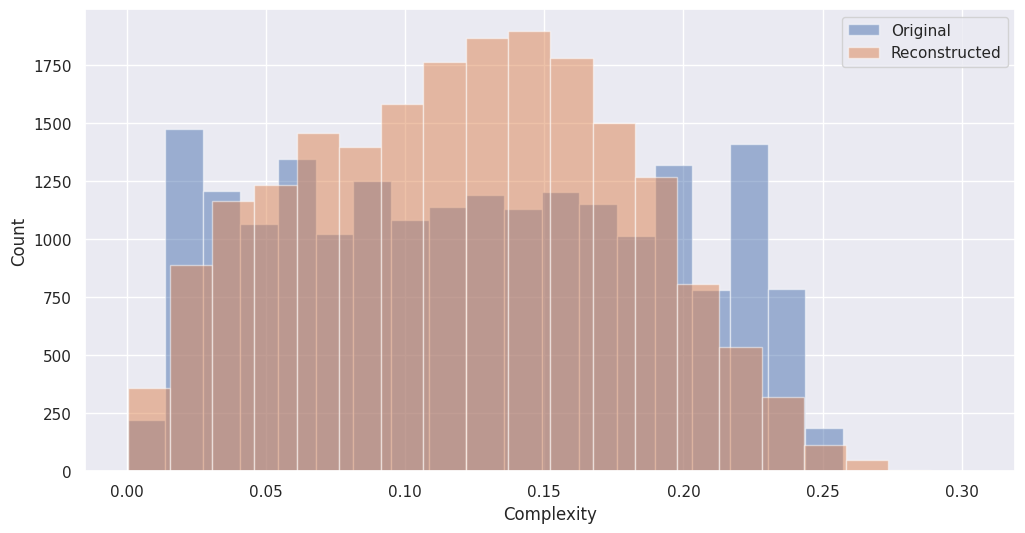

In [29]:
# Plot a histogram of the original and reconstructed complexities
plt.figure(figsize=(12,6))

plt.hist(complexities, bins=20, alpha=0.5, label="Original")
plt.hist(complexities_hat, bins=20, alpha=0.5, label="Reconstructed")

plt.xlabel("Complexity")
plt.ylabel("Count")
plt.legend()

plt.show()

6359


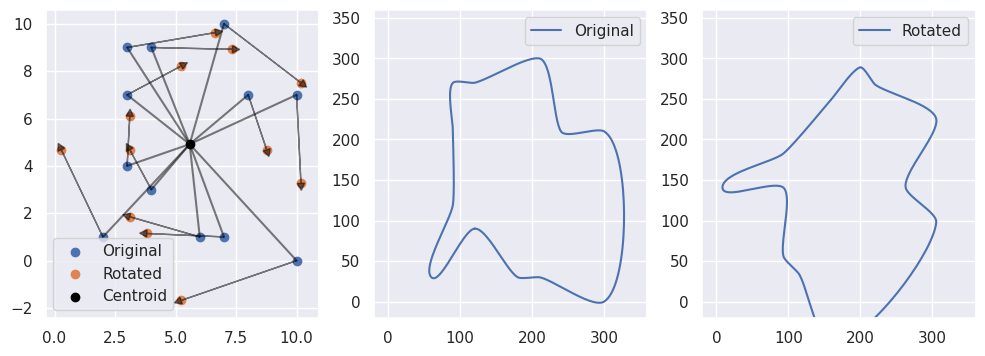

In [61]:
idx = np.random.choice(range(X.shape[0]), 1, replace=False)[0]
print(idx)

# Rotate the points of X[idx] around the centroid
centroid = X[idx].mean(axis=0)
angle = 45
theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
X_rotated = np.dot(X[idx] - centroid, R) + centroid

plt.figure(figsize=(12,4))

plt.subplot(131)
# Plot the original and rotated points
plt.scatter(X[idx][:,0], X[idx][:,1], label="Original")
plt.scatter(X_rotated[:,0], X_rotated[:,1], label="Rotated")

plt.scatter(centroid[0], centroid[1], color="black", label="Centroid")

# Plot lines from the centroid to each point
for i in range(12):
    plt.plot([centroid[0], X[idx][i,0]], [centroid[1], X[idx][i,1]], color="black", alpha=0.5)
    #plt.plot([centroid[0], X_rotated[i,0]], [centroid[1], X_rotated[i,1]], color="black", alpha=0.5)

# Plot arrows from the original to the rotated points
for i in range(12):
    plt.arrow(X[idx][i,0], X[idx][i,1], X_rotated[i,0]-X[idx][i,0], X_rotated[i,1]-X[idx][i,1], color="black", alpha=0.5, head_width=0.3, head_length=0.3)

plt.legend()

plt.subplot(132)
# Plot the original and rotated tracks
control_points, x, y = get_track(X[idx]*30, np_random=np_random)
plt.plot(x, y, label="Original")
plt.xlim(-20,360)
plt.ylim(-20,360)
plt.legend()

plt.subplot(133)
control_points, x, y = get_track(X_rotated*30, np_random=np_random)
plt.plot(x, y, label="Rotated")
plt.xlim(-20,360)
plt.ylim(-20,360)
plt.legend()


In [62]:
X[idx], X_rotated

(array([[ 2.,  1.],
        [ 3.,  4.],
        [ 3.,  7.],
        [ 3.,  9.],
        [ 4.,  3.],
        [ 4.,  9.],
        [ 6.,  1.],
        [ 7.,  1.],
        [ 7., 10.],
        [ 8.,  7.],
        [10.,  0.],
        [10.,  7.]], dtype=float32),
 array([[ 0.28003263,  4.68096447],
        [ 3.10845976,  6.09517803],
        [ 5.2297801 ,  8.21649838],
        [ 6.64399366,  9.63071194],
        [ 3.10845976,  4.68096447],
        [ 7.35110045,  8.92360516],
        [ 3.10845976,  1.85253735],
        [ 3.81556654,  1.14543057],
        [10.17952757,  7.5093916 ],
        [ 8.76531401,  4.68096447],
        [ 5.2297801 , -1.68299656],
        [10.17952757,  3.26675091]]))

In [56]:
# Convert to polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

# Convert to cartesian coordinates
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

X_rotated_polar = np.array([cart2pol(x, y) for x, y in X_rotated])

# Sort the points by the radius
X_rotated = X_rotated[X_rotated_polar[:,0].argsort()]

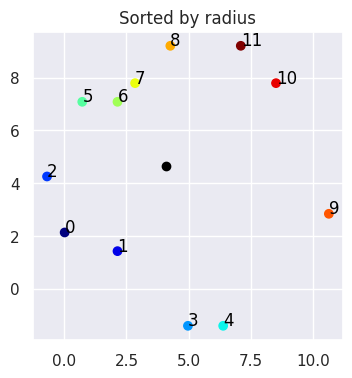

In [59]:
# Plot points
plt.figure(figsize=(4,4))
plt.scatter(X_rotated[:,0], X_rotated[:,1], c=range(12), cmap="jet")

for i in range(12):
    plt.text(X_rotated[i,0], X_rotated[i,1], str(i), fontsize=12, color="black")
plt.title("Sorted by radius")
plt.scatter(centroid[0], centroid[1], color="black", label="Centroid")

________________________________________

In [84]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [171]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [174]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 24, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 48, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 24, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, image_channels, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [175]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

def train(vae, data, epochs=50, bs=32):
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
    for epoch in range(epochs):
        for y, x in data:
            x = x.to(device)
            recon_x, mu, logvar = vae(x)
            loss, bce, kld = loss_fn(recon_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
            print(to_print, end="\r")
        print()

In [252]:
vae = VAE(z_dim=12).to(device) # GPU

data = DataLoader(dataset, batch_size=32, shuffle=True)

train(vae, data, epochs=100)

/home/juan/.virtualenvs/masters_thesis_ws-iu67oo5c/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100] Loss: 33.682 33.513 0.16900
Epoch[2/100] Loss: 33.216 33.105 0.111
Epoch[3/100] Loss: 34.715 34.628 0.087
Epoch[4/100] Loss: 33.761 33.645 0.116
Epoch[5/100] Loss: 30.335 30.205 0.131
Epoch[6/100] Loss: 30.176 30.048 0.127
Epoch[7/100] Loss: 29.624 29.489 0.136
Epoch[8/100] Loss: 30.005 29.865 0.140
Epoch[9/100] Loss: 27.678 27.531 0.147
Epoch[10/100] Loss: 27.773 27.632 0.141
Epoch[11/100] Loss: 27.115 26.966 0.149
Epoch[12/100] Loss: 27.815 27.680 0.136
Epoch[13/100] Loss: 29.031 28.899 0.132
Epoch[14/100] Loss: 26.080 25.933 0.147
Epoch[15/100] Loss: 25.513 25.367 0.146
Epoch[16/100] Loss: 27.355 27.219 0.135
Epoch[17/100] Loss: 26.263 26.120 0.143
Epoch[18/100] Loss: 25.579 25.434 0.145
Epoch[19/100] Loss: 25.164 25.016 0.147
Epoch[20/100] Loss: 25.724 25.581 0.143
Epoch[21/100] Loss: 25.830 25.677 0.154
Epoch[22/100] Loss: 25.094 24.943 0.151
Epoch[23/100] Loss: 26.367 26.228 0.139
Epoch[24/100] Loss: 24.019 23.868 0.151
Epoch[25/100] Loss: 25.697 25.550 0.147
Epoch[2

In [225]:
# Save VAE model
torch.save(vae.state_dict(), f"vae_{IMG_SIZE}x{IMG_SIZE}_2.pt")

In [12]:
# Load VAE model
vae = VAE(z_dim=4).to(device) # GPU
vae.load_state_dict(torch.load(f"vae_{IMG_SIZE}x{IMG_SIZE}_4.pt"))

<All keys matched successfully>

In [6]:
# Plot reconstruction

n_images = 4

plt.figure(figsize=(8,int(4*3)))

for i in range(n_images):
    j = np.random.randint(0, X.shape[0])
    x = dataset[j][0].unsqueeze(0).to(device)
    y = dataset[j][1].unsqueeze(0).to(device)
    recon_x, _, _ = vae(x)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze()

    plt.subplot(5,3,1+3*i)
    plt.imshow(x.cpu().squeeze())

    plt.subplot(5,3,1+3*i+1)
    plt.imshow(recon_x)

    plt.subplot(5,3,1+3*i+2)
    plt.scatter(y.cpu().squeeze()[:,0], y.cpu().squeeze()[:,1], c=range(100), s=10, cmap="viridis")
    plt.xlim(75,225)
    plt.ylim(75,225)

NameError: name 'X' is not defined

<Figure size 800x1200 with 0 Axes>

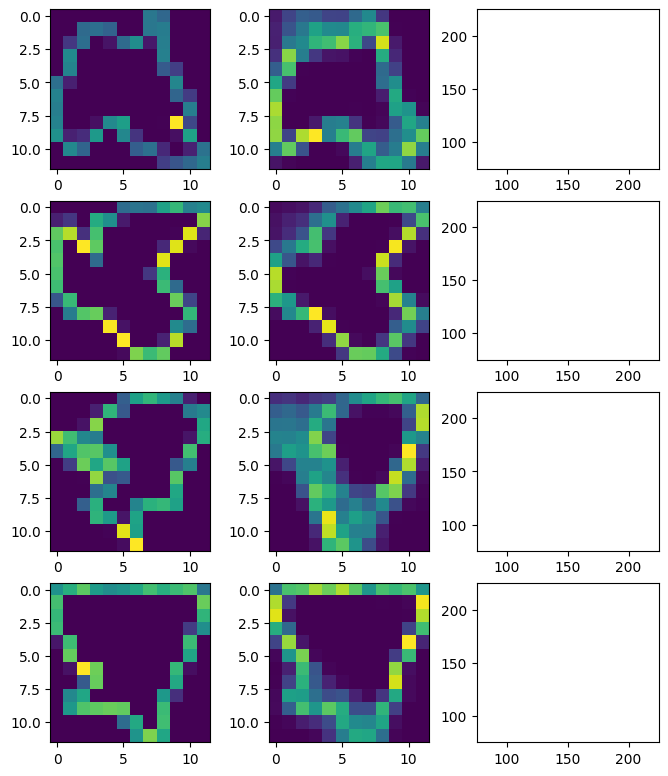

In [253]:
# Plot reconstruction

n_images = 4

plt.figure(figsize=(8,int(4*3)))

for i in range(n_images):
    j = np.random.randint(0, X.shape[0])
    x = dataset[j][1].unsqueeze(0).to(device)
    recon_x, _, _ = vae(x)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze()

    plt.subplot(5,3,1+3*i)
    plt.imshow(x.cpu().squeeze())

    plt.subplot(5,3,1+3*i+1)
    plt.imshow(recon_x)

    plt.subplot(5,3,1+3*i+2)
    #plt.scatter(y.cpu().squeeze()[:,0], y.cpu().squeeze()[:,1], c=range(100), s=10, cmap="viridis")
    plt.xlim(75,225)
    plt.ylim(75,225)

## Convert images to track coordinates

In [36]:
import alphashape

def get_control_points_from_image(img):
    """Image must have uint8 values from 0 to 255"""
    
    # Sharpen image
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    img = np.where(img < 30, 0, img)

    y, x = np.where(img != 0)
    # Calculate center
    center = [int(x.mean()), int(y.mean())]
    points_2d = np.array([x,y]).T
    # Fill contour
    for point in points_2d:
        cv2.line(img, point, center, color=255, thickness=1)
    points_2d = np.array(np.where(img > 100)).T
    # Get alpha shape
    alpha_shape = alphashape.alphashape(points_2d, alpha=0.6)
    geom_type = alpha_shape.geom_type
    alpha = 0.6
    while geom_type == "MultiPolygon":
        alpha -= 0.01
        alpha_shape = alphashape.alphashape(points_2d, alpha=alpha)
        geom_type = alpha_shape.geom_type

    points = np.array([xy for xy in alpha_shape.exterior.coords])
    points = fit_spline(points, num_points=300)

    return points*350/IMG_SIZE


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def fit_spline(points, num_points=200):
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=5, s=10) for coords in points.T]

    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 1, num_points)
    points_fitted = np.vstack([spl(alpha) for spl in splines]).T

    return points_fitted

#### Reconstruct images using variational autoencoder (VAE)

Reconstruct randomly sampled vector from latent space

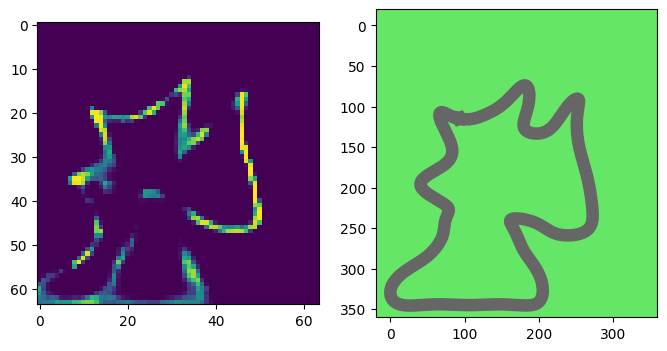

In [59]:
# Reconstruct image from latent space vector
noise = torch.randn(1, 24).to(device)
recon_x = vae.decode(noise).to('cpu').detach().numpy().squeeze()
#Get control points from image
recon_x = (recon_x*255).astype(np.uint8)
control_points = get_control_points_from_image(recon_x)
x, y = control_points[:,0], control_points[:,1]

# Plot track & image
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(recon_x)

plt.subplot(122)
plot_track(np.array([x, y]).T)
plt.gca().invert_yaxis()

Reconstruct real tracks from dataset

In [23]:
# Random index
j = np.random.randint(0, X.shape[0])
# Get data
img_orig = dataset[j][0].unsqueeze(0).to(device)
# Reconstruct image using VAE
recon_x, _, _ = vae(img_orig)
recon_x = recon_x.to('cpu').detach().numpy().squeeze()
# Get control points from image
recon_x = (recon_x*255).astype(np.uint8)

___________

### Visualize latent space

Histogram of latent variables

In [401]:
# Encode data
z_params = vae_model.encoder(torch.tensor(X_sorted).float().to(device).view(-1, 24)).to(device)
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
X_encoded = vae_model.reparameterize(mu, logvar)

(array([1.000e+00, 2.000e+00, 1.600e+01, 7.700e+01, 2.530e+02, 6.010e+02,
        1.267e+03, 2.109e+03, 3.028e+03, 3.404e+03, 3.260e+03, 2.710e+03,
        1.744e+03, 8.870e+02, 4.030e+02, 1.670e+02, 5.300e+01, 1.400e+01,
        3.000e+00, 1.000e+00]),
 array([-4.27067184, -3.83360457, -3.39653707, -2.9594698 , -2.52240229,
        -2.08533502, -1.64826763, -1.21120024, -0.77413291, -0.33706555,
         0.10000181,  0.5370692 ,  0.97413653,  1.41120386,  1.84827125,
         2.28533864,  2.72240591,  3.15947342,  3.59654069,  4.03360796,
         4.47067547]),
 <BarContainer object of 20 artists>)

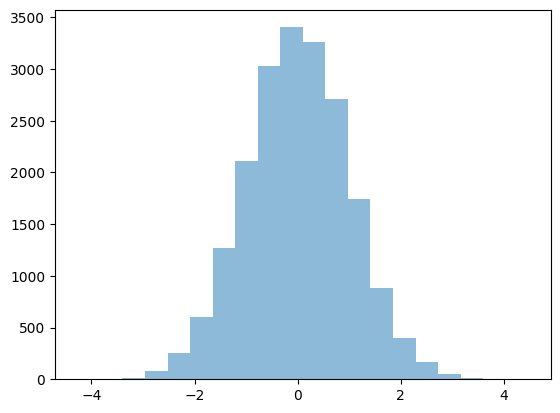

In [404]:
i = 1
plt.hist(X_encoded[:,i].detach().cpu().numpy(), bins=20, alpha=0.5)

2d plot showing the distribution of tracks in the latent space

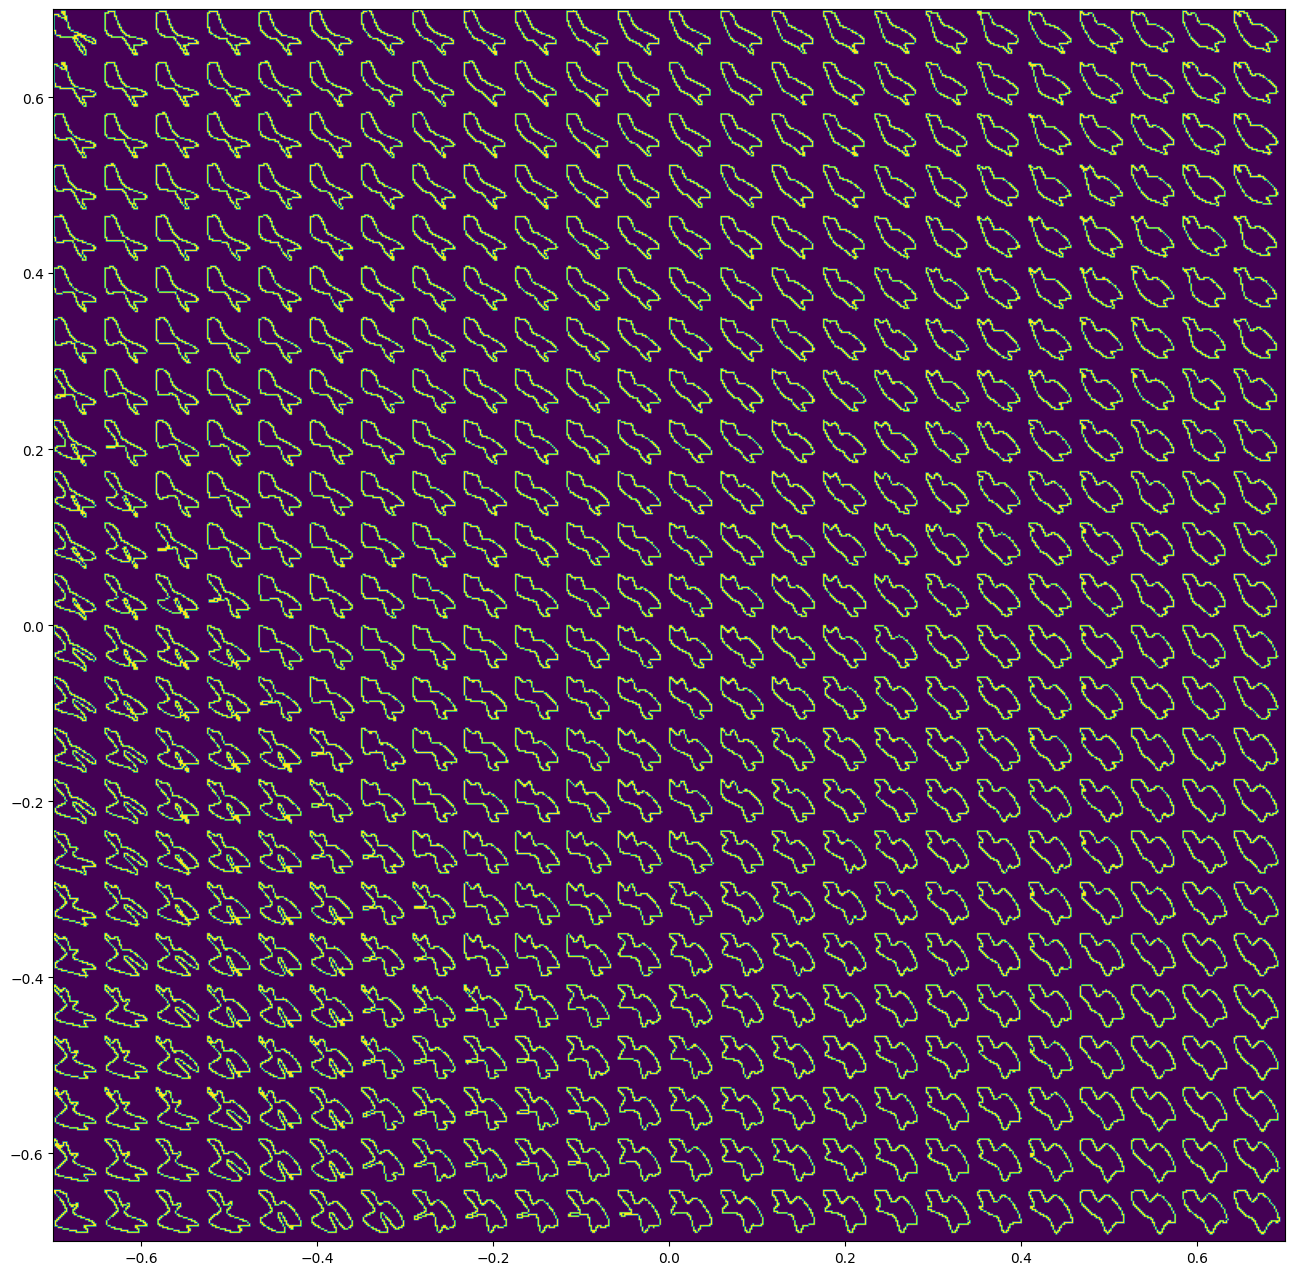

In [416]:
latent_dim = 12

# Generate vector with random values
z_ = np.random.rand(1, latent_dim)

n = 24  # Number of points

lower_limit = -0.7
upper_limit = 0.7

r0 = (lower_limit, upper_limit)
r1 = (lower_limit, upper_limit)

c1 = 0  # Element to vary
c2 = 7

img_size = (32, 32)
w = img_size[0]
img = np.zeros((n*w, n*w))

plt.figure(figsize=(16,16))
# Variate the first element of the vector from -3 to 3
for i, x in enumerate(np.linspace(*r0, n)):
    for j, y in enumerate(np.linspace(*r1, n)):
        z = z_.copy()
        z[0,c1] = x
        z[0,c2] = y
        z = torch.tensor(z).to(device).ravel().float()
        # Reconstruct image using VAE
        recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(12,2)
        control_points, x_, y_ = get_track(control_points=recon_x*30, np_random=np_random)
        track = np.array([x_, y_]).T
        track_img = get_image(track, img_size=img_size)
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = track_img
plt.imshow(img, extent=[*r0, *r1])

In [728]:
# Create a gif from the images
import imageio

images = []

rows, cols = range(n), range(n)

# Create a gif from the images of the first column
for row in rows:
#for col in cols:
    col = 191
    #row = 160
    images.append(img[row*w:(row+1)*w, col*w:(col+1)*w]*255)

images = images + images[::-1]

In [729]:
# Create a gif from the images
imageio.mimsave(f'vae_{latent_dim}_latent_space.gif', images, duration=30, format="GIF")

In [2]:
import matplotlib.patches as patches
import numpy as np

# Define the rectangle parameters
width = 10
height = 8
center = (5, 5)
corner_radius = 1

# Create a rounded rectangle
rectangle = patches.Rectangle(center, width, height, corner_radius)

# Generate 12 equally spaced angles
theta = np.linspace(0, 2*np.pi, num=12)

# Calculate the points on the rectangle
points = [(center[0] + (width/2)*np.cos(t), center[1] + (height/2)*np.sin(t)) for t in theta]

# Round the points
points = np.array(points).round()

points

[[10.  5.]
 [ 9.  7.]
 [ 7.  9.]
 [ 4.  9.]
 [ 2.  8.]
 [ 0.  6.]
 [ 0.  4.]
 [ 2.  2.]
 [ 4.  1.]
 [ 7.  1.]
 [ 9.  3.]
 [10.  5.]]


/tmp/ipykernel_1138/2994872859.py:11: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  rectangle = patches.Rectangle(center, width, height, corner_radius)


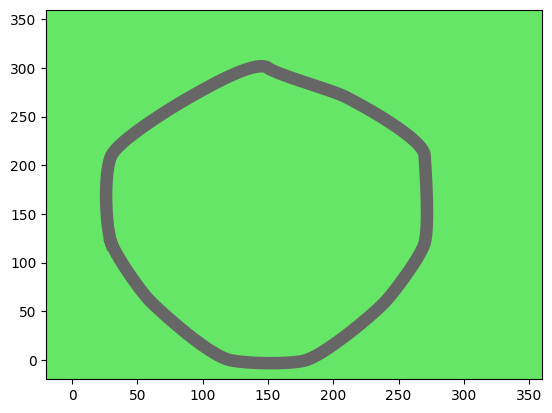

In [433]:
checkpoints, x, y = get_track(points*30, np_random=np_random)
track = np.array([x,y]).T
plot_track(track)

In [434]:
points = torch.tensor(points).to(device).float().reshape(1,-1)
# Encode
z_params = vae_model.encoder(points)
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
z = vae_model.reparameterize(mu, logvar)
#z = z.to('cpu').detach().numpy().squeeze()

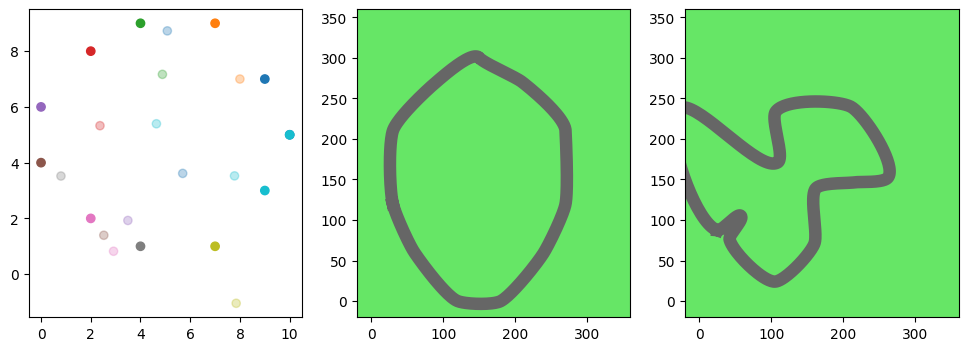

In [442]:
control_points, x_, y_ = get_track(control_points=points.reshape(12,2).cpu().numpy()*30)
track = np.array([x_, y_]).T
recon_x, _, _ = vae_model.to(device)(points)
recon_x = recon_x.to('cpu').detach().numpy().squeeze()
recon_x = recon_x.reshape(12,2)
control_points_recon, x_recon, y_recon = get_track(control_points=recon_x*30)
track_recon = np.array([x_recon, y_recon]).T

plt.figure(figsize=(12,4))

# Plot original points and reconstructed points
plt.subplot(1,3,1)
plt.scatter(points.reshape(12,2).cpu().numpy()[:,0], points.reshape(12,2).cpu().numpy()[:,1], cmap="tab10", c=range(12))
plt.scatter(recon_x[:,0], recon_x[:,1], cmap="tab10", alpha=0.3, c=range(12))

# Plot original track
plt.subplot(1,3,2)
plot_track(track)

# Plot reconstructed track
plt.subplot(1,3,3)
plot_track(track_recon)

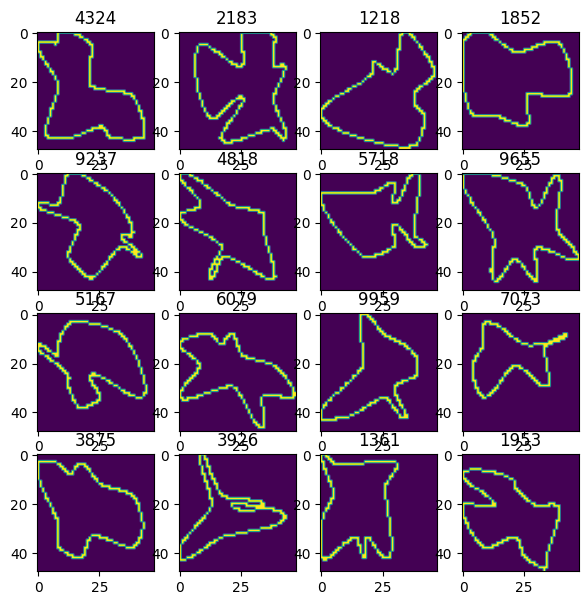

In [259]:
plt.figure(figsize=(7,7))

for j in range(16):

    i = random.randint(0, X.shape[0]-1)

    checkpoints, x, y = get_track(control_points=X[i]*30, np_random=np_random)
    track = np.array([x, y]).T
    img = get_image(track, img_size=(48,48))

    plt.subplot(4,4,j+1)
    plt.imshow(img)
    plt.title(i)
    
plt.show()

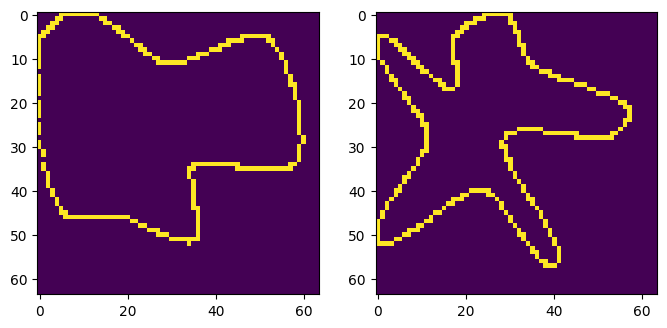

In [260]:
# Easy tracks: 8183, 1852
# Hard tracks: 9470, 5867

img_size = (64,64)

plt.figure(figsize=(8,4))

index_easy = 1852
plt.subplot(121)
checkpoints, x, y = get_track(control_points=X[index_easy]*30, np_random=np_random)
track = np.array([x, y]).T
plt.imshow(get_image(track, img_size=img_size))

plt.subplot(122)
index_hard = 5867
checkpoints, x, y = get_track(control_points=X[index_hard]*30, np_random=np_random)
track = np.array([x, y]).T
plt.imshow(get_image(track, img_size=img_size))

In [404]:
points_easy = reorder_coordinates(X[index_hard], X[index_easy]).flatten()
points_hard = X[index_hard].flatten()

points_easy = control_points_list[0]
points_hard = control_points_list[1]
points_easy = reorder_coordinates(points_hard, points_easy)
points_easy = points_easy.flatten()
points_hard = points_hard.flatten()

# Interpolate between points_easy and points_hard
n = 300
points = np.zeros((n, points_easy.shape[0]))
for i in range(points_easy.shape[0]):
    points[:,i] = np.linspace(points_easy[i], points_hard[i], n)

points = points.reshape(n, 12, 2)

images = []
img_size = (256, 256)

for i in range(points.shape[0]):
    control_points, x_, y_ = get_track(control_points=points[i,:,:]*30, np_random=np_random)
    track = np.array([x_, y_]).T
    img = get_image(track, img_size=img_size)*255
    # Dilation operation
    kernel = np.ones((4,4),np.uint8)
    img = cv2.dilate(img, kernel, iterations=2)
    images.append(img)

images = images + images[::-1]

In [386]:
points_easy = X[index_easy]
points_hard = X[index_hard]

# Encode
z_params = vae_model.encoder(torch.tensor(points_easy).to(device).float().reshape(1,-1))
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
z_easy = vae_model.reparameterize(mu, logvar)
z_easy = z_easy.to('cpu').detach().numpy().squeeze()

# Encode
z_params = vae_model.encoder(torch.tensor(points_hard).to(device).float().reshape(1,-1))
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
z_hard = vae_model.reparameterize(mu, logvar)
z_hard = z_hard.to('cpu').detach().numpy().squeeze()

# Interpolate between z_easy and z_hard
n = 300
z_interp = np.zeros((n, latent_dim))
for i in range(latent_dim):
    z_interp[:,i] = np.linspace(z_easy[i], z_hard[i], num=n)

In [407]:
images = []
img_size = (256, 256)

control_points_list = []

for i in range(z_interp.shape[0]):
    z = z_interp[i,:]
    z = torch.tensor(z).to(device).ravel().float()
    # Reconstruct image using VAE
    recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(12,2)
    control_points, x_, y_ = get_track(control_points=recon_x*30, np_random=np_random)
    track = np.array([x_, y_]).T
    img = get_image(track, img_size=img_size)*255
    # Dilation operation
    kernel = np.ones((4,4),np.uint8)
    img = cv2.dilate(img, kernel, iterations=2)
    images.append(img)

    if i == 0 or i == n-1:
        control_points_list.append(control_points)

images = images + images[::-1]

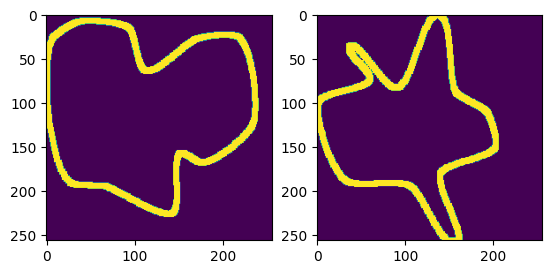

In [408]:
plt.subplot(121)
plt.imshow(images[0])

plt.subplot(122)
plt.imshow(images[n])

In [409]:
import imageio
# Create a gif from the images
imageio.mimsave(f'vae_{latent_dim}_easy-hard_latent-space-interp.gif', images, duration=20, format="GIF")